In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import xgboost as xgb
import tensorflow as tf

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings(action='ignore')

# **1. Data Importing**

In [ ]:
# importing dataset
from google.colab import files

files.upload()

In [3]:
df=pd.read_csv('dataset_phishing.csv')

features_names = list(df.columns[1:-1])

In [ ]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [4]:
# splitting data and target

data = df.drop(['url','status'],axis=1).values
target = df['status'].values

In [5]:
# labeling targets as 0 or 1, where 1 is for phishing

le = preprocessing.LabelEncoder()
y = le.fit_transform(target)

# **2. Data Exploring**

In [ ]:
data.shape

(11430, 87)

In [ ]:
target.shape

(11430,)

In [ ]:
# Showing all the columns in dataset with their types and non-null occurences
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [ ]:
# Showing data statistics

df.describe().applymap('{:,.2f}'.format)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,"11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00",...,"11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00"
mean,61.13,21.09,0.15,2.48,1.00,0.02,0.14,0.16,0.00,0.29,...,0.12,0.78,0.44,0.07,492.53,"4,062.54","856,756.64",0.02,0.53,3.19
std,55.30,10.78,0.36,1.37,2.09,0.16,0.36,0.82,0.00,1.00,...,0.33,0.42,0.50,0.26,814.77,"3,107.78","1,995,606.02",0.14,0.50,2.54
min,12.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,-1.00,-12.00,0.00,0.00,0.00,0.00
25%,33.00,15.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,84.00,972.25,0.00,0.00,0.00,1.00
50%,47.00,19.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,242.00,"3,993.00","1,651.00",0.00,1.00,3.00
75%,71.00,24.00,0.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,449.00,"7,026.75","373,845.50",0.00,1.00,5.00
max,"1,641.00",214.00,1.00,24.00,43.00,4.00,3.00,19.00,0.00,19.00,...,1.00,1.00,1.00,1.00,"29,829.00","12,874.00","10,767,986.00",1.00,1.00,10.00


In [ ]:
# Showing count of sites having HTTPS token
df['https_token'].value_counts()

1    6983
0    4447
Name: https_token, dtype: int64

In [ ]:
# Showing count of sites having a port number in URL
df['port'].value_counts()

0    11403
1       27
Name: port, dtype: int64

In [ ]:
# Showing count of sites having abnormal subdomains in URL
df['abnormal_subdomain'].value_counts()

0    11183
1      247
Name: abnormal_subdomain, dtype: int64

In [ ]:
# Showing count of sites having suspecious top level domain in URL
df['suspecious_tld'].value_counts()

0    11225
1      205
Name: suspecious_tld, dtype: int64

In [ ]:
# Showing count of sites having copyright content
df['domain_with_copyright'].value_counts()

0    6406
1    5024
Name: domain_with_copyright, dtype: int64

In [ ]:
# Converting categorical data
df['is_phishing'] = pd.factorize(df['status'])[0]
df['is_phishing']

0        0
1        1
2        1
3        0
4        0
        ..
11425    0
11426    1
11427    0
11428    0
11429    1
Name: is_phishing, Length: 11430, dtype: int64

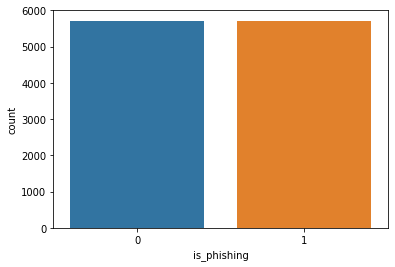

In [ ]:
# Showing Phishing vs Legitimate Websites
sns.countplot(x=df['is_phishing'])
plt.show()

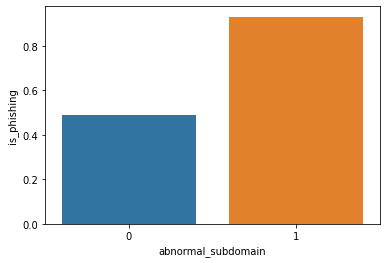

In [ ]:
# Showing Phishing Websites based on abnormal subdomain being present in URL
sns.barplot(x='abnormal_subdomain', y='is_phishing', ci=None, data=df)
plt.show()

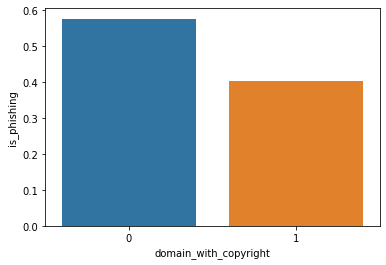

In [ ]:
# Showing Phishing Websites based on domain with copyrights
sns.barplot(x='domain_with_copyright', y='is_phishing', ci=None, data=df)
plt.show()

# **3. Data Pre-processing**

In [6]:
# normalization
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(data) 
print(X)

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y) 
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

[[-0.43632748 -0.19396372 -0.42102044 ...  6.97822701  0.93426411
   0.32097385]
 [ 0.28706655  0.17720743  2.37518157 ... -0.14330288  0.93426411
  -0.46740717]
 [ 1.17322424  2.6826127   2.37518157 ... -0.14330288  0.93426411
  -1.25578819]
 ...
 [ 0.79344237 -0.47234208  2.37518157 ... -0.14330288  0.93426411
   2.68611691]
 [-0.41824263  0.82675695 -0.42102044 ... -0.14330288 -1.07036115
   0.32097385]
 [ 7.52100688 -0.65792766  2.37518157 ...  6.97822701  0.93426411
  -1.25578819]]
X_train shape: (7658, 87)
y_train shape: (7658,)
X_test shape: (3772, 87)
y_test shape: (3772,)


In [ ]:
# Showing statistics of the data after normalization
df_norm = pd.DataFrame(X)
df_norm.describe().applymap('{:,.2f}'.format)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
count,"11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00",...,"11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00","11,430.00"
mean,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,...,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.89,-1.59,-0.42,-1.08,-0.48,-0.14,-0.39,-0.20,0.00,-0.29,...,-0.38,-1.86,-0.89,-0.28,-0.61,-1.31,-0.43,-0.14,-1.07,-1.26
25%,-0.51,-0.57,-0.42,-0.35,-0.48,-0.14,-0.39,-0.20,0.00,-0.29,...,-0.38,0.54,-0.89,-0.28,-0.50,-0.99,-0.43,-0.14,-1.07,-0.86
50%,-0.26,-0.19,-0.42,-0.35,-0.48,-0.14,-0.39,-0.20,0.00,-0.29,...,-0.38,0.54,-0.89,-0.28,-0.31,-0.02,-0.43,-0.14,0.93,-0.07
75%,0.18,0.27,-0.42,0.38,0.00,-0.14,-0.39,-0.20,0.00,-0.29,...,-0.38,0.54,1.13,-0.28,-0.05,0.95,-0.24,-0.14,0.93,0.72
max,28.57,17.90,2.38,15.71,20.13,25.58,7.84,22.94,0.00,18.74,...,2.65,0.54,1.13,3.57,36.01,2.84,4.97,6.98,0.93,2.69


# **4. Models Training and Testing**

## **4.1. SVM**

In [ ]:
# finding best hyperparameters for SVM with RBF kernel

parameters = {'C': 0.5*np.arange(1,50),
              'gamma': 0.005*np.arange(1,8)}
gridCV = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, n_jobs=-1)   # "n_jobs = -1" means "use all the CPU cores".
gridCV.fit(X_train, y_train)
best_C = gridCV.best_params_['C']
best_gamma = gridCV.best_params_['gamma']

print("SVM best C: " + str(best_C))
print("SVM best gamma: " + str(best_gamma))

Training accuracy: 0.988

Testing Accuracy: 0.963
Testing Precision: 0.962
Testing Recall: 0.964
Testing F1 score: 0.963


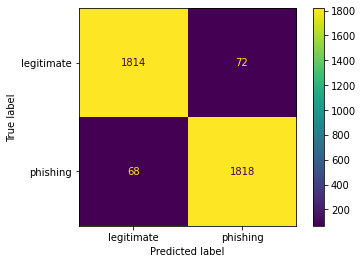

In [7]:
# training SVM model 
best_C = 10
best_gamma = 0.01
SVM_model = SVC(kernel='rbf', C=best_C,gamma=best_gamma)
SVM_model.fit(X_train, y_train)

# evaluating the model on training data
y_pred = SVM_model.predict(X_train) 
accuracy_train = SVM_model.score(X_train, y_train) 
print('Training accuracy:', np.round(accuracy_train,3)) 

# testing SVM model 
y_pred = SVM_model.predict(X_test) 

# calculating metrics
print("\nTesting Accuracy:", np.round(accuracy_score(y_test, y_pred), 3))
print("Testing Precision:", np.round(precision_score(y_test, y_pred), 3))
print("Testing Recall:", np.round(recall_score(y_test, y_pred), 3))
print("Testing F1 score:", np.round(f1_score(y_test, y_pred), 3))

# displaying confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legitimate','phishing'])
disp_cm.plot()
plt.show()

## **4.2. k-NN**

In [ ]:
# k-NN
print("----------------------\n")

accuracy_list = []
accuracy_list_with_k = []

k_range = range(1, 100, 1)
for k in k_range:
  # calculating based on K ranging from 1 to 100 with a step of 1
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_train, y_train)
  y_pred = knn_model.predict(X_test)
  
  # calculating confusion matrix and accuracy with rounding off to 2 decimal points
  confusion_matrix = confusion_matrix(y_test, y_pred)
  accuracy = np.round(accuracy_score(y_test, y_pred), 2)
  
  # appending results to arrays
  accuracy_list.append(accuracy)
  accuracy_list_with_k.append({
      "k_value": k, 
      "accuracy": accuracy
  })
  
  # printing the KNN results
  print("K: " + str(k))
  print(confusion_matrix)
  print("Testing accuracy: " + str(accuracy))
  print("\n-----------------------\n")

In [ ]:
# printing the best and worst KNN results

sorted_accuracy_list = sorted(accuracy_list_with_k, key = lambda x: x["accuracy"])
best_result = sorted_accuracy_list[len(accuracy_list_with_k) - 1]
worst_result = sorted_accuracy_list[0]

print("\n--------------------------------\n")
print("Best accuracy: " + str(best_result["accuracy"]) + " with K: " + str(best_result["k_value"]))
print("\n--------------------------------\n")
print("Worst accuracy: " + str(worst_result["accuracy"]) + " with K: " + str(worst_result["k_value"]))
print("\n--------------------------------\n")


--------------------------------

Best accuracy: 0.94 with K: 7

--------------------------------

Worst accuracy: 0.91 with K: 50

--------------------------------



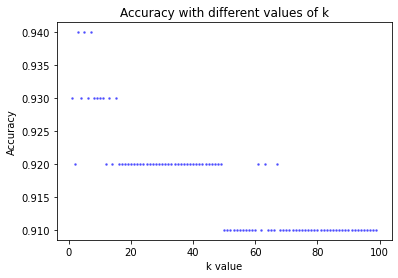

In [ ]:
# Show the KNN results in a scatterplot
plt.scatter(k_range, accuracy_list, c='blue', marker='.', s=10, alpha=0.5)
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Accuracy with different values of k')
plt.show()

# Conclusion: The model gives the best results with K value less than 10

Training Accuracy: 0.95

Testing Accuracy: 0.936
Testing Precision: 0.957
Testing Recall: 0.913
Testing F1 score: 0.934


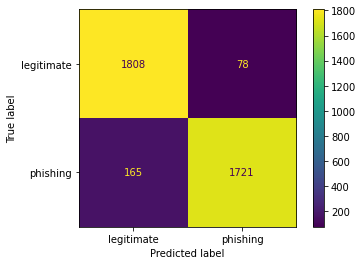

In [ ]:
# training the model using best k_neighbors
best_knn = 7
knn_model = KNeighborsClassifier(n_neighbors = best_knn)
knn_model.fit(X_train, y_train)

# evaluating the model on training data
y_train_pred = knn_model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", np.round(acc_train, 3))

# evaluating the model on testing data
y_pred = knn_model.predict(X_test)

# calculating metrics
print("\nTesting Accuracy:", np.round(accuracy_score(y_test, y_pred), 3))
print("Testing Precision:", np.round(precision_score(y_test, y_pred), 3))
print("Testing Recall:", np.round(recall_score(y_test, y_pred), 3))
print("Testing F1 score:", np.round(f1_score(y_test, y_pred), 3))

# displaying confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legitimate','phishing'])
disp_cm.plot()
plt.show()

## **4.3. Random Forest**

In [ ]:
# finding best hyperparameters

parameters = {'n_estimators': np.arange(20, 200,5), 
              'max_depth': np.arange(1, 10), 
              'min_samples_leaf': np.arange(1,21,2)}
gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(X_train, y_train)
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']

print("Random Forest best n_estimator : " + str(best_n_estim))
print("Random Forest best max_depth : " + str(best_depth))
print("Random Forest best min_samples_leaf : " + str(best_min_samples_leaf))

Training accuracy: 0.966

Testing Accuracy: 0.95
Testing Precision: 0.948
Testing Recall: 0.953
Testing F1 score: 0.951


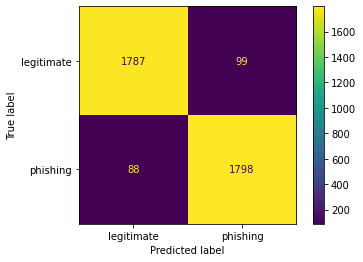

In [8]:
# training the model using best hyperparameters
best_n_estim = 195
best_depth = 9
best_min_samples_leaf = 10
RF_model = RandomForestClassifier(n_estimators=best_n_estim, max_depth=best_depth,
                                  min_samples_leaf=best_min_samples_leaf,random_state=42)
RF_model.fit(X_train, y_train)

# evaluating the model on training data
y_train_pred = RF_model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training accuracy:", np.round(acc_train, 3))

# evaluating the model on testing data
y_pred = RF_model.predict(X_test)

# calculating metrics
print("\nTesting Accuracy:", np.round(accuracy_score(y_test, y_pred), 3))
print("Testing Precision:", np.round(precision_score(y_test, y_pred), 3))
print("Testing Recall:", np.round(recall_score(y_test, y_pred), 3))
print("Testing F1 score:", np.round(f1_score(y_test, y_pred), 3))

# displaying confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legitimate','phishing'])
disp_cm.plot()
plt.show()

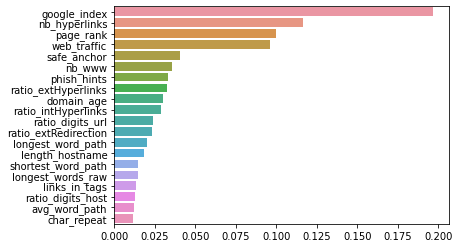

In [ ]:
# Display the top 20 most important variables.
variable_importance = pd.Series(RF_model.feature_importances_, index = features_names)
top_variables_20 = variable_importance.sort_values(ascending=False)[:20]
sns.barplot(x=top_variables_20.values, y = top_variables_20.index, ci=None)
plt.show()

## **4.4. XGBoost**

In [ ]:
# finding best hyperparameters

parameters = {'n_estimators': range(50, 200, 10),
              'max_depth': range (2, 10, 1),
              'learning_rate': [0.1, 0.05]}
gridCV = GridSearchCV(XGBClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(X_train, y_train)
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_learning_rate = gridCV.best_params_['learning_rate']

print("XGBoost best n_estimator: " + str(best_n_estim))
print("XGBoost best max_depth: " + str(best_depth))
print("XGBoost best learning_rate: " + str(best_learning_rate))

Training accuracy: 1.0

Testing Accuracy: 0.969
Testing Precision: 0.963
Testing Recall: 0.976
Testing F1 score: 0.969


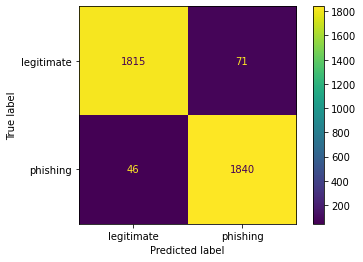

In [9]:
# training the model using best hyperparameters
best_n_estim = 190
best_depth = 5
best_learning_rate = 0.1
XGB_model = XGBClassifier(n_estimators=best_n_estim, max_depth=best_depth,
                          learning_rate=best_learning_rate, objective='binary:logistic',
                          eval_metric='logloss', seed=42)
XGB_model.fit(X_train, y_train)

# evaluating the model on training data
y_train_pred = XGB_model.predict(X_train)
acc_train = accuracy_score(y_train, y_train_pred)
print("Training accuracy:", np.round(acc_train, 3))

# evaluating the model on testing data
y_pred = XGB_model.predict(X_test)

# calculating metrics
print("\nTesting Accuracy:", np.round(accuracy_score(y_test, y_pred), 3))
print("Testing Precision:", np.round(precision_score(y_test, y_pred), 3))
print("Testing Recall:", np.round(recall_score(y_test, y_pred), 3))
print("Testing F1 score:", np.round(f1_score(y_test, y_pred), 3))

# displaying confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legitimate','phishing'])
disp_cm.plot()
plt.show()

## **4.5. Artificial Neural Networks**

In [ ]:
#Define the model architecture

ANN_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(87,), activation='relu', kernel_regularizer=regularizers.l2(0.009)),
    Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.009)),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compile the model
ANN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
print("Training the model....")
history = ANN_model.fit(X_train, y_train, epochs=80, verbose=1, 
                        validation_data=(X_test, y_test))         #Change verbose value to 0, to hide live progress in terminal

#Test the model
print("Testing the model....")
predictions = ANN_model.predict(X_test)
rounded_predictions = np.round(predictions)

#Calculate metrics
accuracy = accuracy_score(y_test, rounded_predictions)
precision = precision_score(y_test, rounded_predictions)
recall = recall_score(y_test, rounded_predictions)
f1 = f1_score(y_test, rounded_predictions)

Training the model....
Epoch 1/80
240/240 [==============================] - 4s 8ms/step - loss: 1.0475 - accuracy: 0.9181 - val_loss: 0.4162 - val_accuracy: 0.9454
Epoch 2/80
240/240 [==============================] - 1s 3ms/step - loss: 0.3076 - accuracy: 0.9445 - val_loss: 0.2391 - val_accuracy: 0.9507
Epoch 3/80
240/240 [==============================] - 1s 3ms/step - loss: 0.2238 - accuracy: 0.9482 - val_loss: 0.2140 - val_accuracy: 0.9491
Epoch 4/80
240/240 [==============================] - 1s 3ms/step - loss: 0.2036 - accuracy: 0.9500 - val_loss: 0.2033 - val_accuracy: 0.9496
Epoch 5/80
240/240 [==============================] - 1s 4ms/step - loss: 0.1986 - accuracy: 0.9488 - val_loss: 0.1976 - val_accuracy: 0.9472
Epoch 6/80
240/240 [==============================] - 1s 4ms/step - loss: 0.1931 - accuracy: 0.9517 - val_loss: 0.1954 - val_accuracy: 0.9472
Epoch 7/80
240/240 [==============================] - 1s 4ms/step - loss: 0.1929 - accuracy: 0.9486 - val_loss: 0.1883 - val_


Model Evaluation:- 

Accuracy: 0.96   ( 96.05 % )
Precision: 0.96
Recall: 0.96
F1 score: 0.96

 



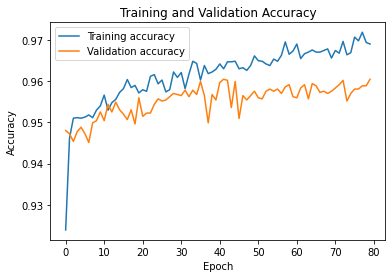

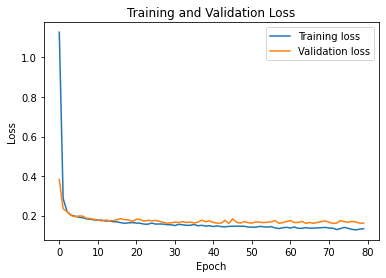

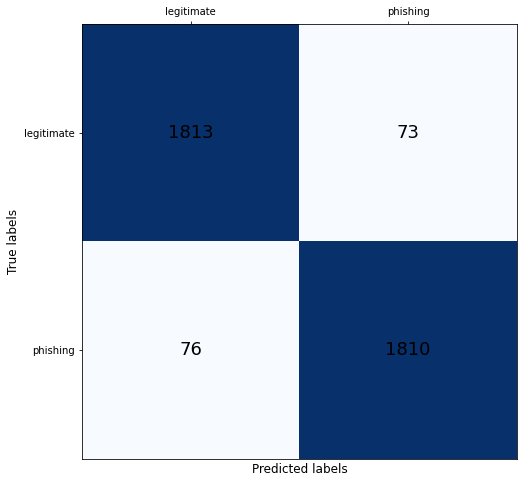

In [ ]:
#Print output with metrics
print("\nModel Evaluation:- \n")
accPerc = accuracy * 100 
print("Testing Accuracy: {:.3f}".format(accuracy) , "  (", round(accPerc , 2) , "% )")
print("Testing Precision: {:.3f}".format(precision))
print("Testing Recall: {:.3f}".format(recall))
print("Testing F1 score: {:.3f}".format(f1))

print("\n \n")
 
#Plot the training and validation accuracy
plt.plot(history.history['accuracy'] , label='Training accuracy')
plt.plot(history.history['val_accuracy'] , label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print("\n \n")
 
#Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("\n \n")
 
#Create the confusion matrix
cm = confusion_matrix(y_test, rounded_predictions)

#Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=12, color='black')
ax.set_ylabel('True labels', fontsize=12, color='black')
ax.xaxis.set(ticks=(0, 1), ticklabels=('legitimate', 'phishing'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('legitimate', 'phishing'))
ax.xaxis.tick_top()
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=18)
plt.show()